In [74]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports
from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL 
from PIL import Image, ImageDraw, ImageFont
import cv2 
from pycocotools.coco import COCO

# Other Imports
from tqdm.notebook import tqdm

LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

In [1]:
import cv2
import os
import seaborn as sns
import json
import multiprocessing as mp
from tqdm import tqdm
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid", {'axes.grid' : False})

In [7]:
import os
os.getcwd()

'/opt/ml/cv18-detection/EDA'

In [8]:
CONFIG = {
    "path_data":"../../dataset/",
    "info_data_train":"train.json",  # images, annotations
    "info_data_test":"val_split.json",
}

In [9]:
with open(os.path.join(CONFIG['path_data'], CONFIG['info_data_train'])) as js:
    json_train = json.load(js)

In [17]:
json_train['annotations'][0]

{'area': 257301.66,
 'bbox': [197.6, 193.7, 547.8, 469.7],
 'category_id': 0,
 'id': 0,
 'image_id': 0,
 'iscrowd': 0}

In [325]:
coco = COCO('/opt/ml/dataset/train.json')

df = pd.DataFrame()

image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
w = []
h = []
id =[]
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_info['id'])
    anns = coco.loadAnns(ann_ids)
        
    file_name = image_info['file_name']
        
    for ann in anns:
        image_ids.append(file_name)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        id.append(ann['id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        w.append(float(ann['bbox'][2]))
        h.append(float(ann['bbox'][3]))

df['image_id'] = image_ids
df['class_name'] = class_name
df['class_id'] = class_id
df['id']=id
df['x_min'] = x_min
df['y_min'] = y_min
df['width'] = w
df['height'] = h

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [326]:
df.sort_values(by='id',inplace=True)

In [327]:
df.reset_index(inplace=True)

In [328]:
df=df.drop(['index'],axis=1)

In [329]:
len(df)

23144

In [330]:
import os
os.getcwd()

'/opt/ml/cv18-detection/EDA'

In [331]:
df['image_id'][0] ,df['x_min'][0]

('train/0000.jpg', 197.6)

In [333]:
global font
font = ImageFont.truetype('SourceCodePro-Regular.ttf',size=40)

In [334]:
df.head(20)

,image_id,class_name,class_id,id,x_min,y_min,width,height
0,train/0000.jpg,General trash,0,0,197.6,193.7,547.8,469.7
1,train/0001.jpg,Metal,3,1,0.0,407.4,57.6,180.6
2,train/0001.jpg,Plastic bag,7,2,0.0,455.6,144.6,181.6
3,train/0001.jpg,Glass,4,3,722.3,313.4,274.3,251.9
4,train/0001.jpg,Plastic,5,4,353.2,671.0,233.7,103.4
5,train/0001.jpg,Plastic,5,5,3.7,448.5,778.2,242.0
6,train/0001.jpg,General trash,0,6,425.3,681.9,216.4,179.8
7,train/0001.jpg,Plastic bag,7,7,92.4,601.7,139.2,53.1
8,train/0001.jpg,General trash,0,8,622.4,686.5,72.8,94.2
9,train/0002.jpg,Metal,3,9,267.9,165.2,631.6,513.0


In [335]:
df[df['id']==31]

,image_id,class_name,class_id,id,x_min,y_min,width,height
31,train/0005.jpg,Paper,1,31,68.1,66.5,125.3,38.3


In [381]:
def show_bbox(df,i,x_p=0,y_p=0,w=0,h=0):
    image_path = '/opt/ml/dataset/' + df['image_id'][i]
    font = ImageFont.truetype('SourceCodePro-Regular.ttf',size=30)
    img = Image.open(image_path)
    color = (255,0,0)

    draw= ImageDraw.Draw(img)
    draw.rectangle([df['x_min'][i],df['y_min'][i],df['x_min'][i]+df['width'][i],df['y_min'][i]+df['height'][i]],outline=color,width=3)
    draw.rectangle([df['x_min'][i]+x_p,df['y_min'][i]+y_p, df['x_min'][i]+df['width'][i] + w,df['y_min'][i]+df['height'][i]+h],outline=(100,255,0),width=1)
    text_pos = (df['x_min'][i]+10,df['y_min'][i]+10)
    draw.text(text_pos, df['class_name'][i],fill= color,font= font)
    print(df[df['id']==i])
    print([df['x_min'][i]+x_p,df['y_min'][i]+y_p, df['width'][i] + w,df['height'][i]+h])

    img.show()
    
    

          image_id   class_name  class_id  id  x_min  y_min  width  height
45  train/0008.jpg  Plastic bag         7  45  170.3    0.0  415.5   210.5
[170.3, 0.0, 415.5, 210.5]


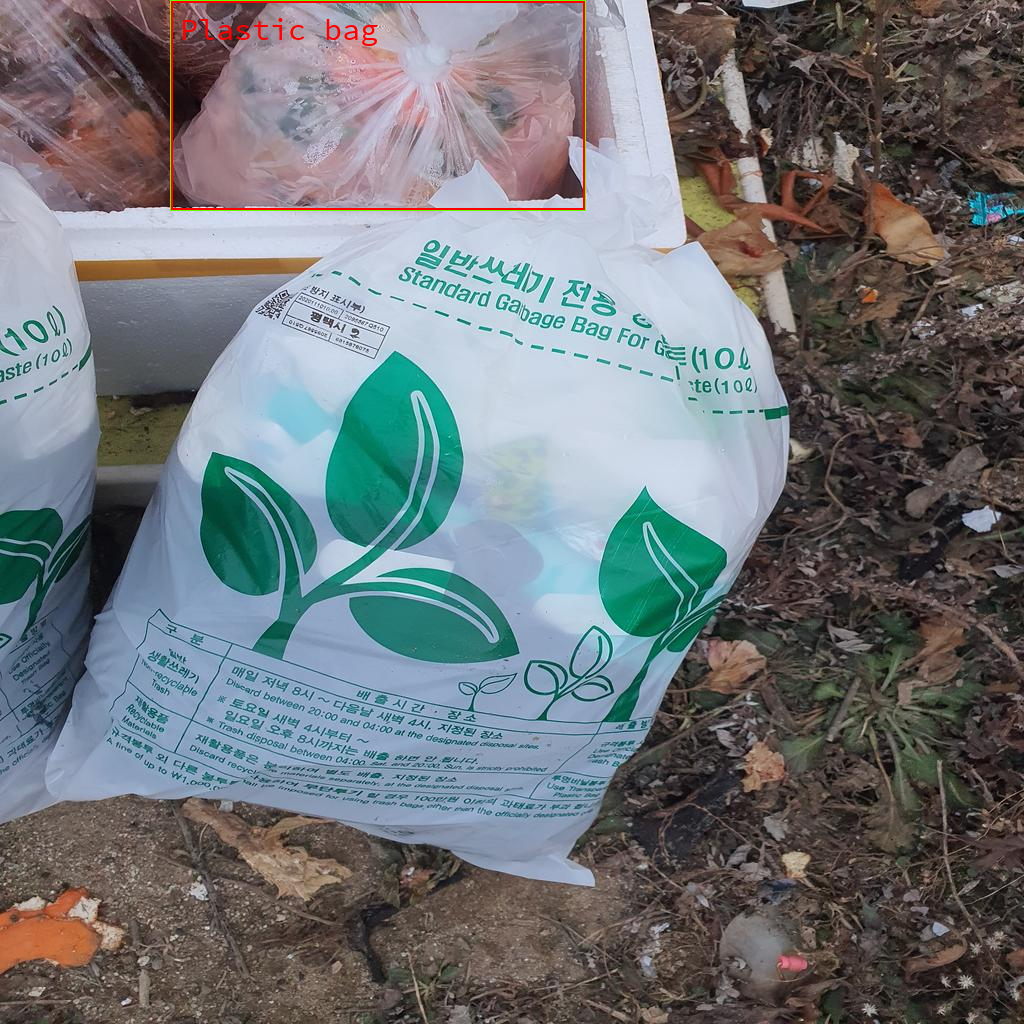

In [382]:
num_id=45
x_p=0
y_p=0
w=0
h=0
show_bbox(df,num_id,x_p,y_p,w,h)
